# Modelos de QSAR

Os modelos QSAR tentam prever a actividade biológica de uma série de compostos a partir da sua estrutura. Estes modelos podem ser quantitativos (regressores) ou quaitativos (classificadores). No caso dos modelos regressores, tenta-se chegar a um valor aproximado da actividade biológica, ao passo que os classificadores apenas permitem obter uma previsão binária (positivo/negativo) relativamente à actividade.

Em ambos os casos, o procedimento de estudo passa pelos seguintes passos:
1. Recolha dos dados de actividade biológica
1. Recolha dos descritores moleculares
1. Cura dos dados
1. Divisão dos dados entre conjunto de treino e conjunto de teste
1. Treino do modelo QSAR
1. Validação do modelo usando os dados de teste
1. Aplicação do modelo aos nossos compostos-problema (para os quais ainda não há informação)

Neste notebook iremos recolher manualmente os dados de actividade a partir do PubChem (Passo 1). Depois os dados serão carregados no notebook (atraves de um ficheiro CSV) e vamos usar a API do PubChem para obter a representação SMILES de cada composto na base de dados (Passo 2a). Os descritores serão então calculados usandoo RDKIT (Passo 2b). Após a divisão dos dados em conjuntos de treino e teste (Passo 3) iremos treinar e validar dois modelos QSAR: um regressor e um classificador. Cada um desses modelos será analisado nas suas características e métricas, e finalmente aplicamos cada um desses modelos a um conjnto de quatro moléculas-problema.

Este tutorial está escrito de forma a que possa ser aplicado a outros conjuntos de dados com alteração mínima (preferencialmente nenhuma) do código python.

## Setup

Esta secção tem as definições de funções necessárias para correr as aplicações de química/design de fármacos.

In [2]:
%%capture
! pip install ase
! pip install py3Dmol
! pip install seaborn
! pip install pubchempy



!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -y -c rdkit rdkit 
!time conda install -y -c conda-forge openbabel
#!time conda install -y gxx_linux-64
#!time conda install -q -y -c conda-forge rdkit
#time conda install  -y -c conda-forge xtb

#wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
#chmod +x Miniconda3-latest-Linux-x86_64.sh
#bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
#conda install  -y -c conda-forge python
#conda install  -y -c conda-forge rdkit
#conda install  -y -c conda-forge xtb
#pip install --user py3Dmol
#pip install --user seaborn

# install XTB
#wget -c https://github.com/grimme-lab/xtb/releases/download/v6.4.0/xtb-210201.tar.xz
#tar xf xtb-210201.tar.xz
#export PATH=/content/xtb-6.4.0/bin:${PATH}
#cd ..



In [33]:
import sys
site_pkg_path='/usr/local/lib/python3.7/site-packages'
if site_pkg_path not in sys.path:
  sys.path.append(site_pkg_path)
import os

import numpy as np
import pandas as pd

from sklearn import compose
from sklearn import metrics
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import pipeline
from sklearn import model_selection

import time
#import ase
import pubchempy
from collections import defaultdict
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDistGeom
IPythonConsole.ipython_3d = True

import py3Dmol
import matplotlib.pyplot as plt
import subprocess
import seaborn as sb

## FUNÇÕES ADMINISTRATIVAS ##

def shell(cmd, shell=True):
  "runs a command in the linux shell, adapted from Jimmy Kromann."
  if shell:
    p = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  else:
    p = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  output, err = p.communicate()
  return output

def run_xtb(args):
  return shell(f"/content/xtb-6.4.0/bin/xtb {args}")

def get_snapshot(dirname='/content/work_dir',fn=None):
  "Downloads work_dir as a tbz file for archive."
  from google.colab import files
  import os
  import time
  origin = os.path.abspath(os.curdir)
  now=time.localtime()
  date_str=f"{now[0]-2000:02d}{now[1]:02d}{now[2]:02d}-{now[3]:02d}{now[4]:02d}"
  ofn = fn if fn else f"{date_str}-{os.path.split(dirname)[-1]}.zip"
  os.chdir(dirname)
  os.chdir('..')
  shell(f"zip -r {ofn} ./{os.path.split(dirname)[-1]}")
  files.download(ofn)
  os.chdir(origin)
  print(f"O ficheiro {ofn} está pronto para download...")

## Funções gráficas ##

def make_fitness_plot(model, x_train, y_train, x_test, y_test, y_name='Property'):
  y_train_pred = model.predict(x_train)
  y_test_pred = model.predict(x_test)
  fig = plt.figure()
  ax = fig.add_subplot(1,1,1)
  l_train = ax.scatter(y_train,y_train_pred)
  l_test = ax.scatter(y_test,y_test_pred)
  y_full=np.concatenate((y_test,y_train))
  l3 = ax.plot(y_full,y_full)
  ax.set_xlabel(f"{y_name} (Original)")
  ax.set_ylabel(f"{y_name} (Predicted)")
  l = ax.legend([l_train,l_test],['Train data','Test data'])
  plt.show()


# Criar a work_dir e mudar para lá
os.chdir('/content/')
try:
  os.mkdir('work_dir')
except:
  print("Pasta 'work_dir' já existe.")
  
os.chdir('/content/work_dir')


Pasta 'work_dir' já existe.


## Passo 1: Recolher os Dados de Actividade do PubChem 

Recolhemos os dados de actividade do pubchem e fazemos upload. 

In [4]:
from google.colab import files

uploaded = files.upload()


Saving activity.csv to activity.csv


Neste exemplo, os dados estão no ficheiro "actividade.csv". O qual só aparece no código python no final da próxima célula de código.

In [5]:
csv_fn="/content/work_dir/activity.csv"

Começamos por carregar o ficheiro csv com o pacote pandas (`pd.read_csv()`) depois há que proceder com alguma inspecção dos dados (descrita em comentário ao código.

In [39]:
# Carregar o ficheiro
data = pd.read_csv(csv_fn)

print(f"Os dados originais têm {len(data)} linhas.")

# Há duas colunas potencialmente problemáticas: acvalue e activity

# em primeiro lugar, nem todas as Activity são Active e Inactive, pelo que vamos
# remover todas as linhas que não cabem dentro desta classificação binária
data=data[(data["activity"]=="Active") | (data["activity"]=="Inactive")]
print(f"Agora os dados têm {len(data)} linhas.")

# finalmente, para certos dados, acvalue está como NaN (not a number)
# vamos alterar isto para 0.0, no caso dos compostos dados como Inactive
# e elimina as linhas que permanecem com NaN
data["acvalue"][data["activity"]=='Inactive'] = 0.0
data=data.dropna()
print(f"No final os dados têm {len(data)} linhas.")

# vamos também remover a coluna acname
data=data.drop("acname", axis=1)

Os dados originais têm 16454 linhas.
Agora os dados têm 11392 linhas.
No final os dados têm 9852 linhas.


## Passo 2: Recolha dos descritores moleculares

Para recolher os SMILES dos 9825 compostos da nossa tabela, usamos o pacote `pubchempy`, que permite fazer pesquisas na pubchem de forma automática usando o python. Neste caso em particular, vamos guardar os vários smiles em sequência numa lista que depois é guardada na base de dados.

Temos que usar um loop do tipo `for` com uma instrução do tipo sleep pelo meio para evitar saturar o servidor da PubChem. No entanto, com um sleep de 0.5, a recuperação dos cerca de 10000 compostos demora cerca de 2 horas (!). Para facilitar a nossa vida, vamos primeiro reduzir os dados a 500 compostos (todos os inactivos e o resto dos dados é preenchido por compostos activos).

In [40]:
# comentar estas linhas se pretender usar todos os dados
data_inactive=data[data['activity']=='Inactive']
n_inactive = len(data_inactive)
data_active=data[data['activity']=='Active'].sample(n=500-n_inactive)
data=pd.concat([data_inactive,data_active])
# A partir daqui não é necessário editar o codigo

smiles_lst=list()

for cid in data['cid']:
  smiles_lst.append(pubchempy.Compound.from_cid(cid).canonical_smiles)
  time.sleep(0.5)

data['SIMLES']=smiles_lst

Neste ponto, podemos querer guardar uma cópia dos dados em formato CSV para documentação do trabalho.

In [41]:
data.to_csv('snapshoot.csv',index=False)

Agora que já temos os SMILES, podemos descartar os CIDs.

In [42]:
data=data.drop('cid',axis=1)

Agora, existe uma lista extensa de descritores disponívels no RdKit (https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors). Para este exemplo vamos usar apenas alguns, que colocamos num dicionário (pares nome e nome da função que o calcula)

In [43]:
descriptor_d = dict()

descriptor_d['MolLogP'] = Chem.Descriptors.MolLogP
descriptor_d['BertzCT'] = Chem.Descriptors.BertzCT
descriptor_d['HallKierAlpha'] = Chem.Descriptors.HallKierAlpha
descriptor_d['Chi0'] = Chem.Descriptors.Chi0
descriptor_d['Chi1'] = Chem.Descriptors.Chi1
descriptor_d['MolWt'] = Chem.Descriptors.MolWt
descriptor_d['HeavyAtomCount'] = Chem.Descriptors.HeavyAtomCount
descriptor_d['NumHAcceptors'] = Chem.Descriptors.NumHAcceptors
descriptor_d['NumHDonors'] = Chem.Descriptors.NumHDonors
descriptor_d['NumHeteroatoms'] = Chem.Descriptors.NumHeteroatoms
descriptor_d['NumRotatableBonds'] = Chem.Descriptors.NumRotatableBonds
descriptor_d['NumValenceElectrons'] = Chem.Descriptors.NumValenceElectrons
descriptor_d['FractionCSP3'] = Chem.Descriptors.FractionCSP3
descriptor_d['TPSA'] = Chem.Descriptors.TPSA
descriptor_d['LabuteASA'] = Chem.Descriptors.LabuteASA
descriptor_d['VSA_EState1'] = Chem.Descriptors.VSA_EState1
descriptor_d['VSA_EState2'] = Chem.Descriptors.VSA_EState2
descriptor_d['VSA_EState3'] = Chem.Descriptors.VSA_EState3
descriptor_d['VSA_EState4'] = Chem.Descriptors.VSA_EState4
descriptor_d['VSA_EState5'] = Chem.Descriptors.VSA_EState5
descriptor_d['VSA_EState6'] = Chem.Descriptors.VSA_EState6
descriptor_d['VSA_EState7'] = Chem.Descriptors.VSA_EState7
descriptor_d['VSA_EState8'] = Chem.Descriptors.VSA_EState8
descriptor_d['VSA_EState9'] = Chem.Descriptors.VSA_EState9
descriptor_d['VSA_EState10'] = Chem.Descriptors.VSA_EState10

In [44]:
descs=dict()

for k in descriptor_d:
  descs=list()
  for smi in data['SIMLES']:
    c = Chem.MolFromSmiles(smi)
    descs.append(descriptor_d[k](c))
  data[k]=descs

data

,acvalue,activity,SIMLES,MolLogP,BertzCT,HallKierAlpha,Chi0,Chi1,MolWt,HeavyAtomCount,...,VSA_EState1,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,VSA_EState10
11557,0.00000,Inactive,C1=CC=C2C=C(C=CC2=C1)NS(=O)(=O)C3=CC=CC=C3C=CC...,3.15920,1091.399248,-3.16,18.570703,12.492332,368.414,26,...,28.112658,11.171898,10.467245,2.223317,-0.750288,19.188584,2.365959,0.000000,-3.862706,0.000000
11558,0.00000,Inactive,C1=CC=C(C=C1)NS(=O)(=O)C2=CC=CC=C2C=CC(=O)NO,2.00600,786.199563,-2.64,16.001789,10.526005,318.354,22,...,27.348347,11.052697,8.455421,2.209957,-0.747019,14.708804,2.349187,0.000000,-3.794061,0.000000
11560,0.00000,Inactive,CC1=C2COC(=O)C2=C(C(=C1OC)CC=C(C)CCC(=O)O)O,2.73322,687.059387,-2.50,17.145900,10.862280,320.341,23,...,10.392532,22.404940,19.149895,3.040892,-0.972732,0.000000,2.680414,3.793845,1.510214,0.000000
11561,0.00000,Inactive,C1=C(N=C(S1)C2C(C(C(O2)COP(=O)(O)OP(=O)(O)OCC3...,-2.30440,1591.757336,-2.53,31.266856,20.171142,669.459,43,...,50.583802,46.954681,42.813997,11.139381,-0.781543,0.000000,-9.481190,-1.798120,-10.727605,0.907707
11673,0.00000,Inactive,CN1CCC=C(C1=O)CCC(=O)NO,0.06050,273.230632,-1.36,10.552042,6.647066,198.222,14,...,0.000000,23.850139,8.267796,2.194482,-0.491744,0.000000,3.211096,0.730684,1.737547,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7627,1.43000,Active,CC1=CC(=CC(=C1)C(=O)N(CCCCCC(=O)NC2=C(C=CC(=C2...,6.51034,1516.892829,-4.91,30.605873,20.778897,576.741,43,...,0.000000,40.606486,5.863627,12.827756,-0.495533,30.955355,2.379087,4.696554,0.000000,0.000000
27,0.00011,Active,C1CC2CC(=O)NC(C(=O)NC(C(=O)NC(C(=O)N2C1)CC3=CC...,2.23930,1315.564590,-4.05,30.890330,21.368214,602.732,44,...,5.051005,68.463813,8.773335,1.756228,-1.296554,15.941393,4.631743,1.012369,0.000000,0.000000
1768,0.02000,Active,C1CCC(CC1)C(=O)NCC2=CC=C(C=C2)C(=O)NC3=C(C=CC(...,5.38460,1071.815417,-3.60,22.338288,15.597357,427.548,32,...,0.000000,25.086234,5.946089,10.740752,0.061023,22.874999,5.482072,0.475497,0.000000,0.000000
2828,0.05000,Active,CCCCN(CC)CC1=C(N=C2N1C=CC(=C2)C=CC(=O)NO)CC,3.03730,736.344474,-2.18,18.233840,12.121253,344.459,25,...,2.135807,18.328745,8.553094,5.686324,-0.548460,3.896077,8.237946,9.543800,0.000000,0.000000


Finalmente temos que fazer um passo de cura: a coluna activity tem os valores de 'active' e 'inactive', mas os nossos modelos apenas distinguem entre 0 e 1 (ou -1 e +1). Portanto, temos que converter os "Active" em 1 e os "Inactive" em 0.

In [60]:
data.loc[data['activity']=='Active','activity'] = 1
data.loc[data['activity']=='Inactive','activity'] = 0
# finalmente, temos que garantir que o computador considera estes 0's e 1's como números
data['activity']=pd.to_numeric(data['activity'])


## Passo 3: Divisão dos dados em treino e teste

O pacote `sklearn` tem uma função adequada para fazer a divisão dos dados. Neste caso, queremos que 60% dos dados sejam usados para o treino e os restantes 40% para o teste (outros racios comuns são 65:35 e 70:30). No exemplo abaixo pedimos para estratificar os dados por actividade, ou seja, pedimos à função que garanta que os conjuntos de treino e de teste tenham a mesma porpoção de casos positivos e negativos.

In [65]:
treino, teste = model_selection.train_test_split(data,train_size=0.60,stratify=data['activity'])

## Passo 4: Modelo de Regressão linear

Este é o modelo mais básico de QSAR, que tenta expressar o valor da actividade como uma combinação linear dos diferentes descritores.

In [21]:
# Primeiro definimos a lista de nomes dos descritores e do target
x_names = list(descriptor_d.keys())
y_name = ['acvalue']

# Depois definimos os valores de treino e de teste
x_train = treino[x_names]
y_train = treino[y_name]

x_test = teste[x_names]
y_test = teste[y_name]

# Estes 4 conjuntos (x_train, y_train, x_test, y_test podem ser usado com qualquer modelo de regressão)

In [29]:
# Agora criamos o modelo

model = linear_model.LinearRegression(fit_intercept=True)

# treinamos o modelo com os dados de treino usando o método fit()
model.fit(x_train,y_train)

# calculamos e imprimimos a métrica por defeito do modelo para o conjunto de treino e teste
rsq_train = model.score(x_train,y_train)
rsq_test = model.score(x_test,y_test)

print(f"O r^2 no conjunto de treino é de {rsq_train:6.4f}")
print(f"O r^2 no conjunto de teste é de  {rsq_train:6.4f}")

O r^2 no conjunto de treino é de 0.1892
O r^2 no conjunto de teste é de  0.1892


Podemos também fazer uma representação gráfica da precisão do modelo (_fitness plot_)

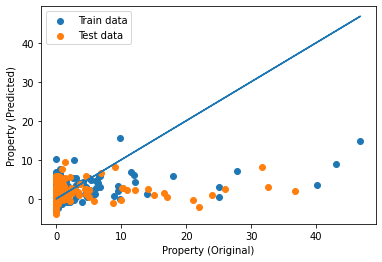

In [34]:
make_fitness_plot(model, x_train, y_train, x_test, y_test)

Em geral, o método de regressão linear funciona bem quando tempos
1. muitos descritores
1. o conjunto contém moléculas estruturalmente próximas

Mas podemos melhorar a performance criando novos descritores que são multiplicação de dois descritores existentes.

In [35]:
poly_maker = preprocessing.PolynomialFeatures(degree=2)

# podemos re-utilizar a maior parte da receita acima
x_train_p = poly_maker.fit_transform(x_train)
x_test_p = poly_maker.fit_transform(x_test)

model = linear_model.LinearRegression(fit_intercept=True)
model.fit(x_train_p,y_train)

rsq_train = model.score(x_train_p,y_train)
rsq_test = model.score(x_test_p,y_test)

print(f"O r^2 no conjunto de treino é de {rsq_train:6.4f}")
print(f"O r^2 no conjunto de teste é de  {rsq_train:6.4f}")

O r^2 no conjunto de treino é de 0.9999
O r^2 no conjunto de teste é de  0.9999


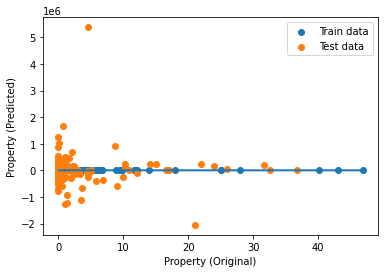

In [36]:
# agora, para visualizar o fitness plot
make_fitness_plot(model, x_train_p, y_train, x_test_p, y_test)

Como podemos ver, o modelo linear continua a ser mau, mas temos um pequeno conjunto de pontos com um erro tão grande, que cria uma situação em que a métrica do $r^2$ dá bons valores para um mau modelo. Nestes casos, o modelo deveria ser treinado com uma métrica diferente.

## Passo 5: Modelo Classificador (Regressão Logística)

Para fazer um modelo classificador, podemos re-utilizar o mesmo x_train e x_test do modelo regressor, mas o nosso y_train e y_test agora tem que conter a variável activity, em vez de acvalue.

In [66]:
# Primeiro definimos a lista de nomes dos descritores e do target
x_names = list(descriptor_d.keys())
y_name = ['activity']

# Depois definimos os valores de treino e de teste
x_train = treino[x_names]
y_train = treino[y_name]

x_test = teste[x_names]
y_test = teste[y_name]

# Estes 4 conjuntos (x_train, y_train, x_test, y_test podem ser usado com qualquer modelo de classificação)

In [68]:
# Criamos o modelo classificador
clf = linear_model.LogisticRegression(max_iter=10_000)

# Fazemos treino do modelo
clf.fit(x_train,y_train)

train_score = clf.score(x_train,y_train)
test_score = clf.score(x_test,y_test)

print(f"Score do conjunto de treino: {train_score}")
print(f"Score do conjunto de teste:  {test_score}")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score do conjunto de treino: 0.9566666666666667
Score do conjunto de teste:  0.935


Os scores são muito promissores. Vamos ver a matris de confusão.

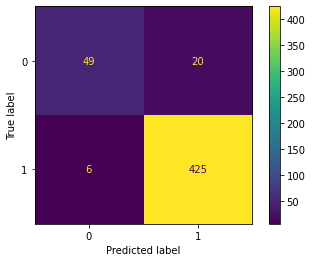

In [69]:
metrics.ConfusionMatrixDisplay.from_estimator(clf,pd.concat([x_train,x_test]),pd.concat([y_train,y_test]))